<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Working with Azure Machine Learning Service

This notebook shows how to monitor the model deployed on Azure Machine Learning Service using Watson OpenScale python sdk.

Contents

1. Setup
2. Binding machine learning engine
3. Subscriptions
4. Performance monitor, scoring and payload logging
5. Quality monitor and feedback logging
6. Fairness monitor and explainability
7. Payload analytics

<a id="setup"></a>
## 1. Setup

### Sample model creation using [Azure Machine Learning Service](https://azure.microsoft.com/en-gb/services/machine-learning-service/)

- #### Run the sample [notebook to create web service (ACI)](https://github.com/pmservice/ai-openscale-tutorials/blob/master/notebooks/Credit%20model%20with%20Azure%20Service%20and%20scikit-learn.ipynb)

### Installation and authentication

In [1]:
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
!pip install --upgrade pyspark --no-cache | tail -n 1
!pip install --upgrade lime==0.1.1.34 --no-cache | tail -n 1

**Action:** Restart the kernel (Kernel->Restart)

Import and initiate.

In [2]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.supporting_classes import PayloadRecord
from ibm_ai_openscale.supporting_classes.enums import InputDataType, ProblemType
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *

#### ACTION: Get Watson OpenScale `apikey`

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using bluemix console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [3]:
API_KEY = 'put your API key here'

In [4]:
# The code was removed by Watson Studio for sharing.

#### Let's define some constants required to set up data mart:

- AIOS_CREDENTIALS
- POSTGRES_CREDENTIALS
- SCHEMA_NAME

In [5]:
from ibm_ai_openscale.utils import get_instance_guid

AIOS_CREDENTIALS = {
  "url": "https://api.aiopenscale.cloud.ibm.com",
  "instance_guid": get_instance_guid(api_key=API_KEY),
  "apikey": API_KEY
}

In [6]:
POSTGRES_CREDENTIALS = {
    "db_type": "postgresql",
    "uri_cli_1": "xxx",
    "maps": [],
    "instance_administration_api": {
        "instance_id": "xxx",
        "root": "xxx",
        "deployment_id": "xxx"
    },
    "name": "xxx",
    "uri_cli": "xxx",
    "uri_direct_1": "xxx",
    "ca_certificate_base64": "xxx",
    "deployment_id": "xxx",
    "uri": "xxx"
}

In [7]:
# The code was removed by Watson Studio for sharing.

In [12]:
SCHEMA_NAME = 'azure_service_db'

Create schema for data mart.

In [13]:
create_postgres_schema(postgres_credentials=POSTGRES_CREDENTIALS, schema_name=SCHEMA_NAME)

In [14]:
client = APIClient(AIOS_CREDENTIALS)

In [15]:
client.version

'2.1.11'

#### Download and preview training data set

In [16]:
!rm -rf credit_risk_training.csv
!wget "https://raw.githubusercontent.com/pmservice/wml-sample-models/master/spark/credit-risk/data/credit_risk_training.csv"

--2019-07-03 13:21:02--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/spark/credit-risk/data/credit_risk_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694222 (678K) [text/plain]
Saving to: ‘credit_risk_training.csv’

100%[======================================>] 694,222     --.-K/s   in 0.02s   

2019-07-03 13:21:02 (27.7 MB/s) - ‘credit_risk_training.csv’ saved [694222/694222]



In [17]:
import pandas as pd

training_data_pd = pd.read_csv(
        "credit_risk_training.csv",
        dtype={'LoanDuration': int, 'LoanAmount': int, 'InstallmentPercent': int, 'CurrentResidenceDuration': int, 'Age': int, 'ExistingCreditsCount': int, 'Dependents': int})

In [18]:
training_data_pd.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


### DataMart setup

In [21]:
client.data_mart.setup(db_credentials=POSTGRES_CREDENTIALS, schema=SCHEMA_NAME)

In [22]:
data_mart_details = client.data_mart.get_details()

<a id="binding"></a>
## 2. Bind machine learning engines

### Bind  `Azure` machine learning studio

Provide credentials using following fields:
- `client_id`
- `client_secret`
- `subscription_id`
- `tenant`

In [23]:
AZURE_ENGINE_CREDENTIALS = {
    "client_id": "***",
    "client_secret": "***",
    "subscription_id": "***",
    "tenant": "***"
}

In [24]:
# The code was removed by Watson Studio for sharing.

In [25]:
binding_uid = client.data_mart.bindings.add('My Azure ML Service', AzureMachineLearningServiceInstance(AZURE_ENGINE_CREDENTIALS))

In [26]:
bindings_details = client.data_mart.bindings.get_details()

In [27]:
client.data_mart.bindings.list()

5aa02882-db8b-486e-9fed-bf201de7ca1a,My Azure ML Service,azure_machine_learning_service,2019-07-03T13:21:30.337Z


<a id="subsciption"></a>
## 3. Subscriptions

### Add subscriptions

List available deployments.

**Note:** Depending on number of assets it may take some time.

In [28]:
client.data_mart.bindings.list_assets(binding_uid=binding_uid)

b17220026885e46280b4c8293f3ce616,ai-ops-aks-mlg-qa,2019-07-02T18:25:58.5088977Z,model,,5aa02882-db8b-486e-9fed-bf201de7ca1a,False
1d0aeabb537f172913cc71a89d701b93,campaign-effectiveness-mlg-qa,2019-07-02T18:08:16.1707412Z,model,,5aa02882-db8b-486e-9fed-bf201de7ca1a,False
a01991859bc568e7f2e0630113c3d281,german-credit-risk-azure-mlg-qa,2019-07-02T18:02:45.8521824Z,model,,5aa02882-db8b-486e-9fed-bf201de7ca1a,False
6087c15ec6885e33807012940e8d427b,german-credit-risk-rohit,2019-06-28T08:37:36.4883007Z,model,,5aa02882-db8b-486e-9fed-bf201de7ca1a,False
d2131068b59b6e4ae946bd970d4896f2,german-credit-risk-azure-hc,2019-06-24T23:24:14.7188195Z,model,,5aa02882-db8b-486e-9fed-bf201de7ca1a,False
fd1c405450a4b466b146991b9253bee9,nyc-taxi-binary-tokyoqa-hc,2019-06-24T23:03:53.3270862Z,model,,5aa02882-db8b-486e-9fed-bf201de7ca1a,False
1fb7638e14a4b6544ea4454475f13d23,fp-german-credit-risk-azs-azure,2019-06-19T02:13:46.2710827Z,model,,5aa02882-db8b-486e-9fed-bf201de7ca1a,False
022d3813f27185621d12dad9fa7355a2,campaign-effectiveness,2019-06-13T08:30:42.2725336Z,model,,5aa02882-db8b-486e-9fed-bf201de7ca1a,False
a561cea5c7642c9df1d14418fd270690,nyc-taxi-multiclass-tokyoqa,2019-06-13T04:53:50.0748277Z,model,,5aa02882-db8b-486e-9fed-bf201de7ca1a,False
317bad17a803c2253c9ecdc0b32183a7,nyc-taxi-regression-tokyoqa,2019-06-13T04:24:04.2145521Z,model,,5aa02882-db8b-486e-9fed-bf201de7ca1a,False
5a73d15cee9f3577d4010c1a3a7a1fd8,nyc-taxi-binary-tokyoqa,2019-06-13T03:46:32.495248Z,model,,5aa02882-db8b-486e-9fed-bf201de7ca1a,False


**Action:** Assign your credit risk source_uid to `source_uid` variable below.

In [29]:
source_uid = '6087c15ec6885e33807012940e8d427b'

In [30]:
feature_columns = ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker']
categorical_columns = ['CheckingStatus', 'CreditHistory', 'LoanPurpose', 'ExistingSavings', 'EmploymentDuration', 'Sex', 'OthersOnLoan', 'OwnsProperty', 'InstallmentPlans', 'Housing', 'Job', 'Telephone', 'ForeignWorker']

In [31]:
subscription = client.data_mart.subscriptions.add(
    AzureMachineLearningServiceAsset(source_uid=source_uid,
                                      binding_uid=binding_uid,
                                      input_data_type=InputDataType.STRUCTURED,
                                      problem_type=ProblemType.BINARY_CLASSIFICATION,
                                      label_column='Risk',
                                      prediction_column='Scored Labels',
                                      probability_column='Scored Probabilities',
                                      feature_columns=feature_columns,
                                      categorical_columns=categorical_columns))

### Get subscriptions list

In [32]:
subscriptions = client.data_mart.subscriptions.get_details()

In [33]:
subscriptions_uids = client.data_mart.subscriptions.get_uids()
print(subscriptions_uids)

['c34b745b-8d71-4c8d-8bb7-5cae01cab19b']


### List subscriptions

In [34]:
client.data_mart.subscriptions.list()

c34b745b-8d71-4c8d-8bb7-5cae01cab19b,german-credit-risk-rohit,model,5aa02882-db8b-486e-9fed-bf201de7ca1a,2019-07-03T13:21:52.945Z


<a id="scoring"></a>
## 4. Scoring and payload logging

### Score the credit risk model and measure response time

In [35]:
import requests
import time
import json

subscription_details = subscription.get_details()
scoring_url = subscription_details['entity']['deployments'][0]['scoring_endpoint']['url']

data = {"input": [{'CheckingStatus': "0_to_200", 'LoanDuration': 31, 'CreditHistory': "credits_paid_to_date",
                           'LoanPurpose': "other",
                           'LoanAmount': 1889, 'ExistingSavings': "100_to_500", 'EmploymentDuration': "less_1",
                           'InstallmentPercent': 3, 'Sex': "female",
                           'OthersOnLoan': "none", 'CurrentResidenceDuration': 3, 'OwnsProperty': "savings_insurance",
                           'Age': 32, 'InstallmentPlans': "none",
                           'Housing': "own", 'ExistingCreditsCount': 1, 'Job': "skilled", 'Dependents': 1,
                           'Telephone': "none", 'ForeignWorker': "yes"},
                          {'CheckingStatus': "no_checking", 'LoanDuration': 13, 'CreditHistory': "credits_paid_to_date",
                           'LoanPurpose': "car_new",
                           'LoanAmount': 1389, 'ExistingSavings': "100_to_500", 'EmploymentDuration': "1_to_4",
                           'InstallmentPercent': 2, 'Sex': "male",
                           'OthersOnLoan': "none", 'CurrentResidenceDuration': 3, 'OwnsProperty': "savings_insurance",
                           'Age': 25, 'InstallmentPlans': "none",
                           'Housing': "own", 'ExistingCreditsCount': 2, 'Job': "skilled", 'Dependents': 2,
                           'Telephone': "none", 'ForeignWorker': "yes"}]}

body = str.encode(json.dumps(data))
headers = subscription_details['entity']['deployments'][0]['scoring_endpoint']['request_headers']

start_time = time.time()
response = requests.post(url=scoring_url, data=body, headers=headers)
response_time = int((time.time() - start_time) *1000)
result = response.json()

print(json.dumps(result, indent=2))

"{\"output\": [{\"Scored Labels\": \"No Risk\", \"Scored Probabilities\": [0.8922524675865824, 0.10774753241341757]}, {\"Scored Labels\": \"No Risk\", \"Scored Probabilities\": [0.8335192848546905, 0.1664807151453095]}]}"


### Store the request and response in payload logging table

In [36]:
records_list = []

for i in range(1, 10):
    records_list.append(PayloadRecord(request=data, response=result, response_time=response_time))

subscription.payload_logging.store(records=records_list)

In [37]:
import time

time.sleep(5)
subscription.payload_logging.describe_table()

        LoanAmount  InstallmentPercent  LoanDuration        Age  \
count    14.000000           14.000000     14.000000  14.000000   
mean   1639.000000            2.500000     22.000000  28.500000   
std     259.437261            0.518875      9.339741   3.632122   
min    1389.000000            2.000000     13.000000  25.000000   
25%    1389.000000            2.000000     13.000000  25.000000   
50%    1639.000000            2.500000     22.000000  28.500000   
75%    1889.000000            3.000000     31.000000  32.000000   
max    1889.000000            3.000000     31.000000  32.000000   

       CurrentResidenceDuration  ExistingCreditsCount  Dependents  \
count                      14.0             14.000000   14.000000   
mean                        3.0              1.500000    1.500000   
std                         0.0              0.518875    0.518875   
min                         3.0              1.000000    1.000000   
25%                         3.0              1.0000

### Check transactions performance data

In [38]:
subscription.performance_monitoring.show_table()

2019-07-03 13:21:54.127000+00:00,362.0,2,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9,,
2019-07-03 13:21:54.127000+00:00,362.0,2,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9,,
2019-07-03 13:21:54.127000+00:00,362.0,2,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9,,
2019-07-03 13:21:54.127000+00:00,362.0,2,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9,,
2019-07-03 13:21:54.127000+00:00,362.0,2,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9,,
2019-07-03 13:21:54.127000+00:00,362.0,2,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9,,
2019-07-03 13:21:54.127000+00:00,362.0,2,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9,,
2019-07-03 13:21:54.127000+00:00,362.0,2,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9,,
2019-07-03 13:21:54.127000+00:00,362.0,2,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9,,


**Note:** It may take few seconds before performance data is populated.

<a id="feedback"></a>
## 5. Feedback logging & quality (accuracy) monitoring

### Enable quality monitoring

You need to provide the monitoring `threshold` and `min_records` (minimal number of feedback records).

In [39]:
subscription.quality_monitoring.enable(threshold=0.7, min_records=10)

### Feedback records logging

Feedback records are used to evaluate your model. The predicted values are compared to real values (feedback records).

You can check the schema of feedback table using below method.

In [40]:
subscription.feedback_logging.print_table_schema()

LoanAmount,integer,True
InstallmentPercent,integer,True
ExistingSavings,string,True
CheckingStatus,string,True
LoanPurpose,string,True
Job,string,True
InstallmentPlans,string,True
OthersOnLoan,string,True
LoanDuration,integer,True
Age,integer,True
CreditHistory,string,True


The feedback records can be send to feedback table using below code.

In [41]:
records = [
    ["no_checking","28","outstanding_credit","appliances","5990","500_to_1000","greater_7","5","male","co-applicant","3","car_other","55","none","free","2","skilled","2","yes","yes","Risk"],
    ["greater_200","22","all_credits_paid_back","car_used","3376","less_100","less_1","3","female","none","2","car_other","32","none","own","1","skilled","1","none","yes","No Risk"],
    ["no_checking","39","credits_paid_to_date","vacation","6434","unknown","greater_7","5","male","none","4","car_other","39","none","own","2","skilled","2","yes","yes","Risk"],
    ["0_to_200","20","credits_paid_to_date","furniture","2442","less_100","unemployed","3","female","none","1","real_estate","42","none","own","1","skilled","1","none","yes","No Risk"],
    ["greater_200","4","all_credits_paid_back","education","4206","less_100","unemployed","1","female","none","3","savings_insurance","27","none","own","1","management_self-employed","1","none","yes","No Risk"],
    ["greater_200","23","credits_paid_to_date","car_used","2963","greater_1000","greater_7","4","male","none","4","car_other","46","none","own","2","skilled","1","none","yes","Risk"],
    ["no_checking","31","prior_payments_delayed","vacation","2673","500_to_1000","1_to_4","3","male","none","2","real_estate","35","stores","rent","1","skilled","2","none","yes","Risk"],
    ["no_checking","37","prior_payments_delayed","other","6971","500_to_1000","1_to_4","3","male","none","3","savings_insurance","54","none","own","2","skilled","1","yes","yes","Risk"],
    ["0_to_200","39","prior_payments_delayed","appliances","5685","100_to_500","1_to_4","4","female","none","2","unknown","37","none","own","2","skilled","1","yes","yes","Risk"],
    ["no_checking","38","prior_payments_delayed","appliances","4990","500_to_1000","greater_7","4","male","none","4","car_other","50","bank","own","2","unemployed","2","yes","yes","Risk"]]

fields = feature_columns.copy()
fields.append('Risk')

subscription.feedback_logging.store(feedback_data=records, fields=fields)

In [42]:
subscription.feedback_logging.show_table()

5990,5,500_to_1000,no_checking,appliances,skilled,none,co-applicant,28,55,outstanding_credit,3,yes,free,2,yes,male,2,car_other,greater_7,Risk,2019-07-03 13:22:05.145298+00:00
3376,3,less_100,greater_200,car_used,skilled,none,none,22,32,all_credits_paid_back,2,yes,own,1,none,female,1,car_other,less_1,No Risk,2019-07-03 13:22:05.145298+00:00
6434,5,unknown,no_checking,vacation,skilled,none,none,39,39,credits_paid_to_date,4,yes,own,2,yes,male,2,car_other,greater_7,Risk,2019-07-03 13:22:05.145298+00:00
2442,3,less_100,0_to_200,furniture,skilled,none,none,20,42,credits_paid_to_date,1,yes,own,1,none,female,1,real_estate,unemployed,No Risk,2019-07-03 13:22:05.145298+00:00
4206,1,less_100,greater_200,education,management_self-employed,none,none,4,27,all_credits_paid_back,3,yes,own,1,none,female,1,savings_insurance,unemployed,No Risk,2019-07-03 13:22:05.145298+00:00
2963,4,greater_1000,greater_200,car_used,skilled,none,none,23,46,credits_paid_to_date,4,yes,own,2,none,male,1,car_other,greater_7,Risk,2019-07-03 13:22:05.145298+00:00
2673,3,500_to_1000,no_checking,vacation,skilled,stores,none,31,35,prior_payments_delayed,2,yes,rent,1,none,male,2,real_estate,1_to_4,Risk,2019-07-03 13:22:05.145298+00:00
6971,3,500_to_1000,no_checking,other,skilled,none,none,37,54,prior_payments_delayed,3,yes,own,2,yes,male,1,savings_insurance,1_to_4,Risk,2019-07-03 13:22:05.145298+00:00
5685,4,100_to_500,0_to_200,appliances,skilled,none,none,39,37,prior_payments_delayed,2,yes,own,2,yes,female,1,unknown,1_to_4,Risk,2019-07-03 13:22:05.145298+00:00
4990,4,500_to_1000,no_checking,appliances,unemployed,bank,none,38,50,prior_payments_delayed,4,yes,own,2,yes,male,2,car_other,greater_7,Risk,2019-07-03 13:22:05.145298+00:00


### Run quality monitoring on demand

By default, quality monitoring is run on hourly schedule. You can also trigger it on demand using below code.

In [43]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run 99fba111-c00b-43ea-848a-3789d80907cd 




initializing
completed

---------------------------
 Successfully finished run 
---------------------------




### Show the quality metrics

In [44]:
subscription.quality_monitoring.show_table()

2019-07-03 13:22:08.566000+00:00,true_positive_rate,bb2cf4d4-fc5e-4d14-bff3-151278da4ae2,0.42857142857142855,,,model_type: original,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9
2019-07-03 13:22:08.566000+00:00,area_under_roc,bb2cf4d4-fc5e-4d14-bff3-151278da4ae2,0.7142857142857143,0.7,,model_type: original,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9
2019-07-03 13:22:08.566000+00:00,precision,bb2cf4d4-fc5e-4d14-bff3-151278da4ae2,1.0,,,model_type: original,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9
2019-07-03 13:22:08.566000+00:00,f1_measure,bb2cf4d4-fc5e-4d14-bff3-151278da4ae2,0.6,,,model_type: original,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9
2019-07-03 13:22:08.566000+00:00,accuracy,bb2cf4d4-fc5e-4d14-bff3-151278da4ae2,0.6,,,model_type: original,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9
2019-07-03 13:22:08.566000+00:00,log_loss,bb2cf4d4-fc5e-4d14-bff3-151278da4ae2,0.6451208770769135,,,model_type: original,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9
2019-07-03 13:22:08.566000+00:00,false_positive_rate,bb2cf4d4-fc5e-4d14-bff3-151278da4ae2,0.0,,,model_type: original,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9
2019-07-03 13:22:08.566000+00:00,area_under_pr,bb2cf4d4-fc5e-4d14-bff3-151278da4ae2,0.9142857142857141,,,model_type: original,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9
2019-07-03 13:22:08.566000+00:00,recall,bb2cf4d4-fc5e-4d14-bff3-151278da4ae2,0.42857142857142855,,,model_type: original,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9


Get all calculated metrics.

In [45]:
deployment_uids = subscription.get_deployment_uids()

In [46]:
metrics = subscription.quality_monitoring.get_metrics(deployment_uid=deployment_uids[0])

### Get metrics as pandas dataframe

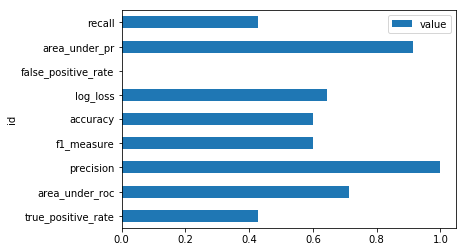

In [47]:
quality_metrics_pandas = subscription.quality_monitoring.get_table_content()

%matplotlib inline
quality_metrics_pandas.plot.barh(x='id', y='value');

## 6. Fairness monitoring and explanations

### Fairness monitor configuration

In [48]:
from ibm_ai_openscale.supporting_classes.feature import Feature

subscription.fairness_monitoring.enable(
            training_data=training_data_pd,
            features=[
                Feature("Sex", majority=['male'], minority=['female'], threshold=0.95),
                Feature("Age", majority=[[26, 75]], minority=[[18, 25]], threshold=0.95)
            ],
            favourable_classes=['No Risk'],
            unfavourable_classes=['Risk'],
            min_records=5
        )

### Run fairness monitor on demand

In [49]:
fairness_run = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=4295edeaf78d9e41fe728b09ae3ca7a9 




RUNNING
FINISHED

---------------------------
 Successfully finished run 
---------------------------




### Show run results

In [50]:
subscription.fairness_monitoring.show_table()

2019-07-03 13:22:22.273936+00:00,Sex,female,False,1.0,100.0,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9,
2019-07-03 13:22:22.273936+00:00,Age,"[18, 25]",False,1.0,100.0,5aa02882-db8b-486e-9fed-bf201de7ca1a,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,c34b745b-8d71-4c8d-8bb7-5cae01cab19b,4295edeaf78d9e41fe728b09ae3ca7a9,


### Explainability configuration

In [51]:
subscription.explainability.enable(training_data=training_data_pd)

### Run explanation

Get sample transaction/scoring id. You can also use `subscription.payload_logging.show_table()` to see list of your transactions (`scoring_id` column).

In [52]:
transaction_id = subscription.payload_logging.get_table_content(limit=1)['scoring_id'][0]
print('Sample transaction/scoring id: ', transaction_id)

Sample transaction/scoring id:  23d7db78-a236-4a98-8528-8d4dc801eb0a-1


In [53]:
explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False)




 Looking for explanation for 23d7db78-a236-4a98-8528-8d4dc801eb0a-1 




in_progress...
finished

---------------------------
 Successfully finished run 
---------------------------




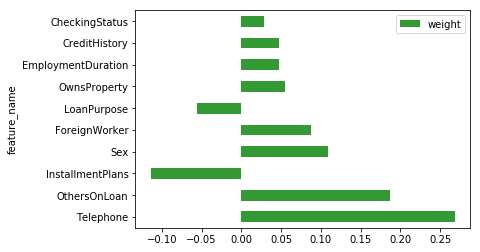

In [54]:
explanation_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])
explanation_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);

## 7. Payload analytics

### Run data distributions calculation

In [55]:
from datetime import datetime

start_date = "2018-01-01T00:00:00.00Z"
end_date = datetime.utcnow().isoformat() + "Z"

sex_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['Scored Labels', 'Sex'],
            agg=['count'])




 Waiting for end of data distribution run 327f0161-d5c9-474d-b094-bc13e8bc7b50 




running
completed

---------------------------
 Successfully finished run 
---------------------------




### Get data distributions as pandas dataframe

In [56]:
sex_distribution_run_uid = sex_distribution['id']

In [57]:
distributions_pd = subscription.payload_logging.data_distribution.get_run_result(run_id=sex_distribution_run_uid, format='pandas')
distributions_pd

,Scored Labels,Sex,count
0,No Risk,female,9
1,No Risk,male,9


### Visualize

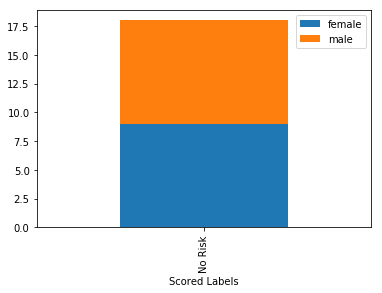

In [58]:
subscription.payload_logging.data_distribution.show_chart(sex_distribution_run_uid);

---

## Congratulations!

You have finished the tutorial for IBM Watson OpenScale and Azure Machine Learning Studio. You can now view the [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). Click on the tile for the German Credit model to see fairness, accuracy, and performance monitors. Click on the timeseries graph to get detailed information on transactions during a specific time window.



---

### Authors
Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.